In [1]:
import experiment
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = torch.load("experiments/baseplate/best.pt")

In [3]:
print(model)

SEMPro_resNext(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ELU(alpha=1.0)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ELU(alpha=1.0)
        (downsample): Sequenti

In [4]:
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

model.fc.weight tensor([[-0.0048, -0.0033, -0.0032,  ..., -0.0198,  0.0115,  0.0083]],
       device='cuda:0')
model.fc.bias tensor([-0.0053], device='cuda:0')


Model Validation

Loading test
dataset size:  (342, 15)
min label:  3.3783979009481375
max label:  4.646599751720373


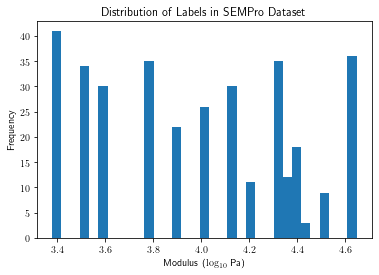

Using re-weighting: [SQRT_INV]
dataset size:  (793, 16)
min label:  1.1760912590556813
max label:  10.635483746814913


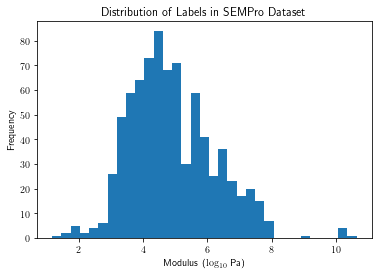

Using re-weighting: [SQRT_INV]
dataset size:  (793, 16)
min label:  1.1760912590556813
max label:  10.635483746814913


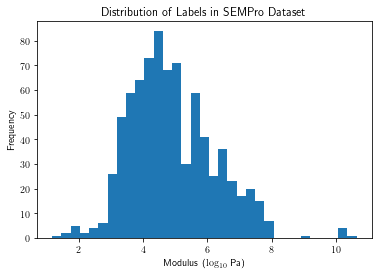

Using re-weighting: [SQRT_INV]
dataset size:  (793, 16)
min label:  1.1760912590556813
max label:  10.635483746814913


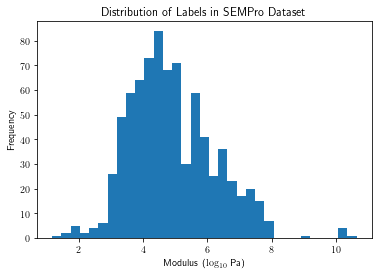

Using re-weighting: [SQRT_INV]
dataset size:  (793, 16)
min label:  1.1760912590556813
max label:  10.635483746814913


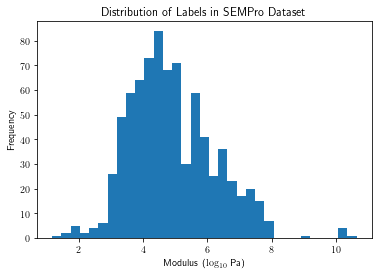

Using re-weighting: [SQRT_INV]
dataset size:  (793, 16)
min label:  1.1760912590556813
max label:  10.635483746814913


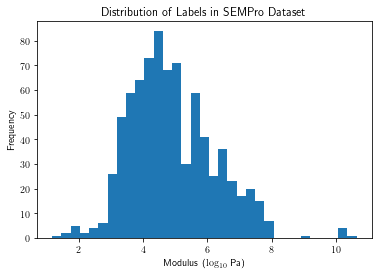

Using re-weighting: [SQRT_INV]
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ELU(alpha=1.0)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (downsample): Sequential(
        (0): Conv2d(

In [2]:
import scipy.stats as stats
import statistics
import numpy as np

baseplate_exp = experiment.Experiment(name="test")
baseplate_exp.set_best_model("experiments/baseplate/best.pt")
baseplate = torch.load("experiments/baseplate/best.pt")

baseplate_scores = []
ctrl_mean_scores = []
ctrl_norm_scores = []

print(len(baseplate_exp.test_data))
print(len(baseplate_exp.all_data))

labels = []

for i in range(len(baseplate_exp.all_data)):
    input_tensor, label, w, _ = baseplate_exp.getExample(3, i)
    labels.append(label.item())

ctrl_norm = np.random.normal(statistics.mean(labels), statistics.stdev(labels), len(labels), )
ctrl_mean = [statistics.mean(labels)] * len(labels)
for i in range(len(baseplate_exp.test_data)):
    input_tensor, label, w, _ = baseplate_exp.getExample(2, i)
    input_tensor = input_tensor.unsqueeze(0)
    actual = baseplate(input_tensor.to(device))
    actual = actual.cpu().detach().numpy()[0][0]
    baseplate_scores.append(abs(label.item()-actual))
    ctrl_mean_scores.append(abs(label.item()-ctrl_mean[i]))
    ctrl_norm_scores.append(abs(label.item()-ctrl_norm[i]))

mean model two-tailed stat: Ttest_relResult(statistic=-2.676080702065243, pvalue=0.0046627773795476415)
norm model two-tailed stat: Ttest_relResult(statistic=-4.381487292979389, pvalue=2.0897638232973446e-05)


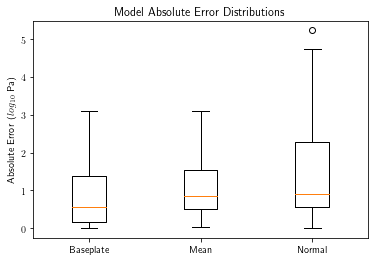

In [4]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots()
ax.boxplot([baseplate_scores, ctrl_mean_scores, ctrl_norm_scores], labels=["Baseplate", "Mean", "Normal"])
ax.set_title("Model Absolute Error Distributions")
ax.set_ylabel(r"Absolute Error ($log_{10}$ Pa)")

x = np.arange(-2,4,0.0001)

# plt.figure()
# plt.title("NC-PNIPAM MAE")
# plt.plot(x,stats.norm.pdf(x,statistics.mean(baseplate_scores),statistics.stdev(baseplate_scores)), label="pnipam")

# plt.plot(x,stats.norm.pdf(x,statistics.mean(ctrl_mean_scores),statistics.stdev(ctrl__mean_scores)), label="pretrained")

# plt.legend()

# print(f"baseplate mean: {statistics.mean(baseplate_scores)}")
# print(f"baseplate std: {statistics.stdev(baseplate_scores)}")

print(f"mean model two-tailed stat: {stats.ttest_rel(a=baseplate_scores, b=ctrl_mean_scores, alternative='less')}")
print(f"norm model two-tailed stat: {stats.ttest_rel(a=baseplate_scores, b=ctrl_norm_scores, alternative='less')}")